<a href="https://colab.research.google.com/github/codebyrohith/Colab-PyTorch-NeuralNetwork/blob/main/Team_4_RNN%2C_LSTM%2C_GRU%2C_and_Explainability_Using_Hugging_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Load dataset
file_path = "Mens Fashion.csv"  # Update with your local path if needed
df = pd.read_csv(file_path)

# Convert price columns to numeric
for col in ["discount_price", "actual_price"]:
    df[col] = df[col].str.replace("₹", "", regex=True).str.replace(",", "", regex=True).astype(float)

# Drop missing values and sort by actual price
df.dropna(subset=["actual_price"], inplace=True)
df = df.sort_values(by="actual_price").reset_index(drop=True)

# Select actual price column
price_data = df[["actual_price"]].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
norm_data = scaler.fit_transform(price_data)

# Function to create sequences
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

# Create sequential dataset
seq_length = 30
X, y = create_sequences(norm_data, seq_length)
X = X.view(X.shape[0], seq_length, 1)

In [ ]:
# Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Define GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Train function
def train_model(model, X, y, epochs=20, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y.view(-1, 1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 5 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

    return losses, model

In [ ]:
# Initialize and train models
rnn_losses, rnn_model = train_model(RNNModel(input_size=1, hidden_size=64, output_size=1), X, y)
lstm_losses, lstm_model = train_model(LSTMModel(input_size=1, hidden_size=64, output_size=1), X, y)
gru_losses, gru_model = train_model(GRUModel(input_size=1, hidden_size=64, output_size=1), X, y)

Epoch 0, Loss: 0.7415
Epoch 5, Loss: 0.2831
Epoch 10, Loss: 0.0008
Epoch 15, Loss: 0.0612
Epoch 0, Loss: 1.2474
Epoch 5, Loss: 1.0782
Epoch 10, Loss: 0.9030
Epoch 15, Loss: 0.6708
Epoch 0, Loss: 0.8112
Epoch 5, Loss: 0.5481
Epoch 10, Loss: 0.3177
Epoch 15, Loss: 0.1191


In [ ]:
# Evaluate models
def evaluate_model(model, X, y):
    with torch.no_grad():
        predictions = model(X).numpy()
    mse = mean_squared_error(y.numpy(), predictions)
    rmse = np.sqrt(mse)
    return mse, rmse

rnn_mse, rnn_rmse = evaluate_model(rnn_model, X, y)
lstm_mse, lstm_rmse = evaluate_model(lstm_model, X, y)
gru_mse, gru_rmse = evaluate_model(gru_model, X, y)

# Print evaluation results
print(f"RNN - MSE: {rnn_mse:.4f}, RMSE: {rnn_rmse:.4f}")
print(f"LSTM - MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}")
print(f"GRU - MSE: {gru_mse:.4f}, RMSE: {gru_rmse:.4f}")


RNN - MSE: 0.0014, RMSE: 0.0372
LSTM - MSE: 0.2690, RMSE: 0.5186
GRU - MSE: 0.0026, RMSE: 0.0506


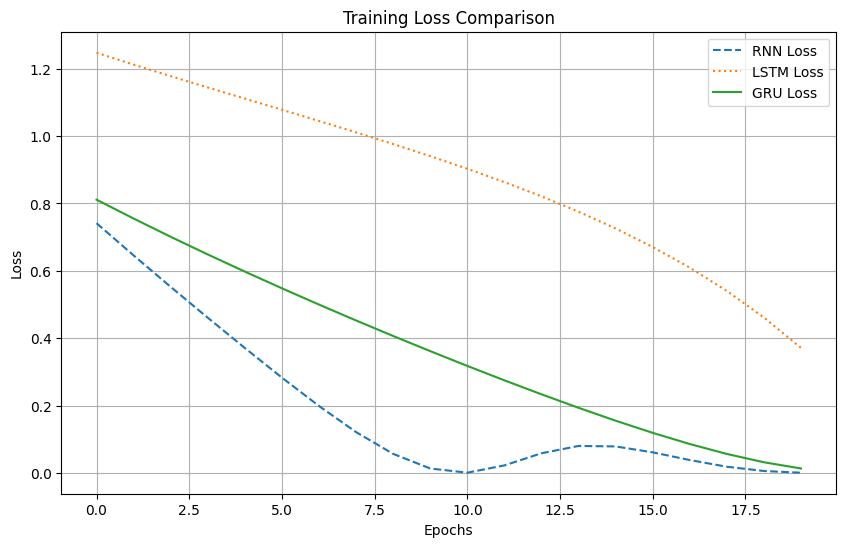

In [ ]:
# Plot Training Loss
plt.figure(figsize=(10,6))
plt.plot(rnn_losses, label='RNN Loss', linestyle='dashed')
plt.plot(lstm_losses, label='LSTM Loss', linestyle='dotted')
plt.plot(gru_losses, label='GRU Loss', linestyle='solid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
pip install transformers

In [ ]:
from transformers import pipeline

# Load a better model (GPT-2)
explainer = pipeline("text-generation", model="gpt2")

# Define new prompts
prompts = [
    "Why does RNN perform worse than LSTM and GRU in sequential data processing?",
    "Why does LSTM handle long-term dependencies better than RNN?",
    "Why does GRU train faster than LSTM while maintaining similar performance?"
]

# Generate explanations
for prompt in prompts:
    explanation = explainer(prompt, max_length=100, truncation=True)
    print(f"\nPrompt: {prompt}\nExplanation: {explanation[0]['generated_text']}")


Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Why does RNN perform worse than LSTM and GRU in sequential data processing?
Explanation: Why does RNN perform worse than LSTM and GRU in sequential data processing?

A. There are many ways to interpret RNN. Some are based on a simplified model and some on a fully implemented (and not so simplified) version of the model. These are not in and of themselves "best". One important thing to remember is that they're not going to come in all "best". A completely new and improved RNN system based on the best approach to optimization will improve


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Why does LSTM handle long-term dependencies better than RNN?
Explanation: Why does LSTM handle long-term dependencies better than RNN?

With the LSTM package, the code changes often. For instance, running a test against a single variable with the default values can cause a different result: the LSTM test doesn't generate the same results. In that case you run the test against a single variable without making changes; if it fails your test is useless!

LSTM also has some problems when interacting with dependencies which include:

Prompt: Why does GRU train faster than LSTM while maintaining similar performance?
Explanation: Why does GRU train faster than LSTM while maintaining similar performance?

For any LRU training, there is a small risk that one or both methods may not work as well as expected. For LSTM training, LRU is an extreme train, so some LRU training may have some limitations while LSTM train is a more in-depth challenge. In this case, GRU is used mainly to train t